The use of “hate speech” and harassment online is a treat not only from a social point of views, but also economically and politically speaking. Therefore, the ability to classify comments, post, messages, etc. in the proper way, it is becoming every day more impelling for all online platforms.

The dataset, provided in the Kaggle [“Toxic Comment Classification Challenge”](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview). It is composed by an extraction of Wikipedia comments, which have been manually pre-labelled according to their level of toxicity. The classes identified are “toxic”, “severe toxic”, “obscene”, “threat”, “insult” and “identity hate”.

We will be using several NLP algorithms to try to predict the level of toxicty of the comments provided. In this specific notebook, we will train our benchmark model, `Bag of Words`, which will be at the basis of all other NLP models that will be used. 

### 1. Bag of Word - Benchmarking model

The first step in our analysis is to define a benchmarking model. This will allow us to evaluate afterwards more complex NLP algorithms. In this optic, we will apply test classification, by using one of the basic model, the so called `Bag of Words`. 

In this framework, we will use a sklearn implementation of Bag of Words, `TfidfVectorizer` to convert the provided text into a numerical matrics. On top of this matrix, we will than apply `Logistic Regression`, `RandomForest` and a `Nayve Bayes` algorithm. We will than select the one which is providing the best result measured on a validation data set.

As we are facing a `Multi-Output Classification` problem, in order to train our model, we will use the sklearn `Multi Output Classifier` to predict the level of toxicity of the target validation dataset within the 6 pre-set labels: `toxic`, `severe toxic`, `obscene`, `threat`, `insult` and `identity hate`. 

#### a. Importing the required libraries

In [3]:
import pandas as pd   #import pandas
import numpy as np   #import numpy
import matplotlib.pyplot as plt   #visualisation library
import seaborn as sns   #visualisation library

import re   # import regex library

import nltk.corpus 
from nltk.corpus import stopwords   # import library for stepword
from nltk.stem.porter import PorterStemmer  # import library for Stemming
from nltk.stem import WordNetLemmatizer   # import library for lemmattazing

from sklearn.feature_extraction.text import TfidfVectorizer   # import TfidfVectorizer

# import library to split dataset into train and test (validation) dataset
from sklearn.model_selection import train_test_split   

from sklearn.datasets import make_multilabel_classification   # library for multi label classification
from sklearn.multioutput import MultiOutputClassifier   # library for the MultiOutputClassifier 
from sklearn.neighbors import KNeighborsClassifier   # library for the KNeighborsClassifier algorithm

# datset used for dataset classification as well as clustering
from sklearn.datasets import load_iris   

from sklearn.linear_model import LogisticRegression   # import library for LogisticRegression
from sklearn.metrics import roc_auc_score   # import library for our evaluation metrics

from sklearn.pipeline import make_pipeline    # create an ML pipeline

# standardizes a feature by subtracting the mean and then scaling to unit variance
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC   # library for Support Vector Classification model
from sklearn.model_selection import RandomizedSearchCV    # library for hyperparameters optimisation
from scipy.stats import uniform   # obtain a uniform distribution
from sklearn import linear_model, datasets   # required library 
from sklearn.model_selection import RandomizedSearchCV   # library for hyperparameters optimisation
from sklearn.ensemble import RandomForestClassifier   # library for RandomForest algorithm
from sklearn.neighbors import KNeighborsClassifier   # library for Kneighbors clustering
from sklearn.naive_bayes import MultinomialNB   # library for Naive Bayes Multinomial algorithm

#### b. Importing the File and EDA analysis

In [4]:
# Load and Read the two dataset, Train and Test
df_train = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/train.csv")   # used to train our model
df_test = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/test.csv")   # used to make prediction

In [5]:
# Let's analyse the first 5 rows of the  train dataset
df_train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
# Let's describe the training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


As we can observe from the above code there are no null value in our dataset. 

- in the `train dataset` we have 159571 comments, which coressponds to our dataframe of manual classified comments from wikipedia.
- id and `comment_txt` are considered as string;
- all the labels (`toxic`, `severe_toxic`, etc.) has a value equal to 0 or 1 depending if it is classified as e.g., `toxic` (i.e., 1) or `not-toxic` (i.e., 0) in the correspondent `comment_text` row. 

Let's have a look now to the test dataset provided

In [7]:
# Let's analyse the first 5 rows of the provided test dataset
df_test.head(5) 

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
#Let's describe the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


As we can observe from the above description of the test dataframe: 
- we have 153164 comments rows, which coressponds to the wikipedia comments to be labelled.
- id and `comment_txt` are considered as string;
- there are no Null values.

The fact that in both cases there are no Null values means that we don't have to perform any cleaning in that sense. As we know Null values are placeholder that needs to be cleaned before being analysied by any ML model. 


Let's try now to have a closer look to the distribution of the manual added labels in the train dataset. 

In [7]:
df_train.shape[0]

159571

In [8]:
# Let's analyse how many labelled comments we have by summing all the 1 for the different label-columns

columns = (df_train.columns).tolist()   # create a list with the columns header
columns = columns[2:]   # drop all columns that are not labels column (i.e., id and comment)

for i in columns:
    c = df_train[i].sum()
    print("The total label for the category {} are {} out of the {} comments in the training dataset."
          " This is the {}% of the total in the {} category. This also mean that {}% is a not {} comments.\n"
          .format(i, c, df_train.shape[0], np.round(c/df_train.shape[0],2), i, 1-np.round(c/df_train.shape[0],3), i))

The total label for the category toxic are 15294 out of the 159571 comments in the training dataset. This is the 0.1% of the total in the toxic category. This also mean that 0.904% is a not toxic comments.

The total label for the category severe_toxic are 1595 out of the 159571 comments in the training dataset. This is the 0.01% of the total in the severe_toxic category. This also mean that 0.99% is a not severe_toxic comments.

The total label for the category obscene are 8449 out of the 159571 comments in the training dataset. This is the 0.05% of the total in the obscene category. This also mean that 0.947% is a not obscene comments.

The total label for the category threat are 478 out of the 159571 comments in the training dataset. This is the 0.0% of the total in the threat category. This also mean that 0.997% is a not threat comments.

The total label for the category insult are 7877 out of the 159571 comments in the training dataset. This is the 0.05% of the total in the insult

As we can notice from the above code, there are several comments in the training dataset for which we don't have any labels per each label categories. This is simphotmatic of an uneven distribution of the label in each label category. Something we will need to take into account when we will apply oiur ML model. 

For example if we consider the label `toxic`, we will notice that 90% of the comments are `non-toxic` and so on for all other categories. 

When we will apply any of the NLP algorithms, we will need to consider this specificity. If we keep the example of the `toxic` label, by the structure of the inheritate train dataset, the porbsability of having a non-toxic comments will be surely high as again 90% of the comments are already non-toxic.

This can be noticed also by the below barchart: 

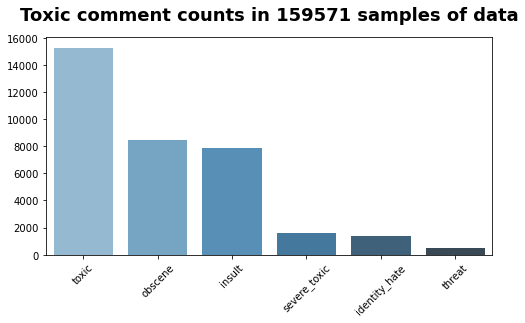

In [9]:
import warnings 
warnings.filterwarnings("ignore")   # ignore possible warnign messages


# Sum all the labels per category
label_counts = df_train.drop(['id', 'comment_text'], axis = 1)
label_counts = label_counts.sum()
df_label_counts = pd.DataFrame(label_counts)   # Transform to a DataFrame
df_label_counts.rename(columns = {0:'counts'}, inplace = True)   # Rename columns
df_label_counts = df_label_counts.sort_values('counts', ascending = False)   # Sort values

# Plot the graph showing the count per label
fig, ax = plt.subplots(figsize = (8,4));
p = sns.barplot(df_label_counts.index, df_label_counts['counts'],palette="Blues_d");
x = plt.xticks(rotation = 45); 
ax.set_title('Toxic comment counts in '+ str(len(df_train))+ 
             ' samples of data', weight = 'bold', fontsize = 18, y = 1.05);
x = ax.set_ylabel('');

It may be also interesting to analyse if this unbalance distribution and tendency through the `Non-labelled` is only for some of the label,e.g., `toxic`, or for all of them. 

In [10]:
# drop unecessary columns
unlabelled_columns = df_train.drop(['id', 'comment_text'], axis = 1)

#filter only the unlabelled comments, i.e., == 0
unlabelled_tot = unlabelled_columns.iloc[:,0:] == 0

print("The percentage of unlabelled comments across all categories is {}%"
      .format(unlabelled_tot.query("toxic == True").count()[0]/len(df_train)))

The percentage of unlabelled comments across all categories is 0.9041555169799024%


It is therfore more clear that for all categories the % of `Non-labelled` is grather than the one of labelled comments.

As in this project we are applying NLP text classification alorithms, it will be also interesting to analyse the train comments structure, like the comments characheters lenght. 

In [11]:
# Create a comments dataframe and check len of each comments
df_comments = df_train
df_comments["comments_len"] = df_train['comment_text'].apply(lambda x: len(str(x)))

In [12]:
# Check some values min-max
df_comments["comments_len"].describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comments_len, dtype: float64

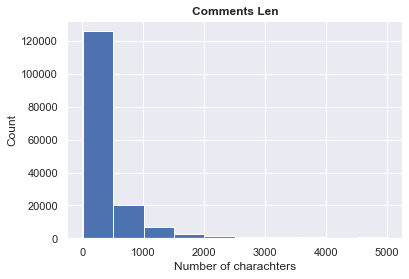

In [13]:
# plot an histogram
sns.set()
df_comments["comments_len"].hist()
plt.title("Comments Len",weight = 'bold')
plt.xlabel('Number of charachters')
plt.ylabel('Count')
plt.show()

Most of the text length are within 400 (mean 394) characters, with some up to 5,000 characters long. This is actually given us the magnitude of the Comments size, which can be useful when we will apply NLP models. 

#### c. Data Pre-Processing

In any Text classification project the importance of text cleaning is absolutely evident. As ML algorithms are sensitive to Null values or to unbalance classes, also the format of text is quite important. For this reason we will implement a function to clean the text. More specifically, we will: 


1. Normalize Text
2. Remove Unicode Characters
3. Remove Stopwords
4. Perform Stemming and Lemmatization

In [14]:
# Download the required function of nltk wrapper for text analysis

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/stefano/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
# Creating a function for text pre-processing, which is a necessary steps for any NLP algorithm.

# inizialize the main function variables
def pre_processing_txt(text, stemm=True, lemm=True, text_stopwords=None):
    
    text = ''.join((word for word in text if not word.isdigit()))    # eliminate all digits from our target text
    
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())   # Regex text + all text lower capital
    
    ## Tokenize our target text (convert from string to list)
    token_text = text.split()
    
    ## remove Stopwords (all english vocabulary that is not providing meaning added value)
    if text_stopwords is not None:
        token_text = [word for word in token_text if word not in 
                    text_stopwords]
                
    ## Stemming process (remove -ing, -ly, ...)
    if stemm == True:
        porter_stemmer = nltk.stem.porter.PorterStemmer()  
        token_text = [porter_stemmer.stem(word) for word in token_text]
                
    ## Lemmatisation (convert the word into root word)
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        token_text = [lem.lemmatize(word) for word in token_text]
            
    ## back to text string from list
    text = " ".join(token_text)
    return text

In [22]:
import sys
sys.setrecursionlimit(10000)

In [25]:
# Test pre_processing_txt function
test = df_train
test["comment_clean"] = df_train.comment_text
test["comment_clean"].apply(pre_processing_txt)


0         explan whi the edit made under my usernam hard...
1         daww he match thi background colour im seeming...
2         hey man im realli not tri to edit war it just ...
3         more i cant make ani real suggest on improv i ...
4         you sir are my hero ani chanc you rememb what ...
                                ...                        
159566    and for the second time of ask when your view ...
159567    you should be asham of yourself that is a horr...
159568    spitzer umm there no actual articl for prostit...
159569    and it look like it wa actual you who put on t...
159570    and i realli dont think you understand i came ...
Name: comment_clean, Length: 159571, dtype: object

In [28]:
#Prepare the dataset to be splitted into Train and Test data
X = df_train.comment_text  #predicotors
y = df_train[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] # independent variable

# Split of the dataset. Test size 33% and random seed = 42
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)  

#### d. Creating Bag of Words through TfidfVectorizer

In [29]:
# Tokenize text comments by using TF-IDF vectorizer

vectorizer = TfidfVectorizer(max_features= 1000, preprocessor=pre_processing_txt)   # max feature 1000

# vectorize the train and test (validation) dataset
X_vec_train = vectorizer.fit_transform(X_train)   
X_vec_test =  vectorizer.fit_transform(X_test)

In [30]:
vectorizer.get_feature_names()

['abl',
 'about',
 'abov',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'accur',
 'accus',
 'across',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'add',
 'addit',
 'address',
 'admin',
 'administr',
 'admit',
 'advertis',
 'advic',
 'afd',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'agre',
 'album',
 'all',
 'alleg',
 'allow',
 'almost',
 'alon',
 'along',
 'alreadi',
 'also',
 'altern',
 'although',
 'alway',
 'am',
 'america',
 'american',
 'among',
 'amount',
 'an',
 'anal',
 'and',
 'ani',
 'anim',
 'anonym',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'anyway',
 'apolog',
 'appar',
 'appear',
 'appli',
 'appreci',
 'appropri',
 'april',
 'arab',
 'archiv',
 'are',
 'area',
 'arent',
 'argu',
 'argument',
 'around',
 'articl',
 'as',
 'ask',
 'assert',
 'associ',
 'assum',
 'at',
 'attack',
 'attempt',
 'attent',
 'august',
 'author',
 'automat',
 'avail',
 'avoid',
 'awar',
 'award',
 'away',
 'back',
 'bad',
 'ban',
 'band',
 'barnstar',
 'base',
 'b

In [31]:
# Compile a LogisticRegression model over the MultiOutputClassifier
# we have decided to run a class weight as "balanced" to try to fix the unbalance per class 
# which is mainly composed by non-labelled classes

lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)) \
                    .fit(X_vec_train, y_train)

In [32]:
# Comute the probability per each comments

y_pred = lr.predict_proba(X_vec_test)

# extract the positive columns for each output
y_pred = np.transpose([pred[:, 1] for pred in y_pred])

#compute the auc_roc probability
auc_roc = roc_auc_score(y_test, y_pred, average=None)

#compute the mean for the 6 clases to have an estimation on how the model is performing
np.mean(auc_roc)

0.6438427396671372

In [33]:
# On the logistic regression try to boost the model with hyperparameters optimization

hyperparameters = dict(estimator__C=uniform(loc=0, scale=4), 
                   estimator__class_weight = "balanced",estimator__max_iter=[2000,3000,4000,5000])

# Use the RandomizedSearchCV function to run 8 fold on the logistic regression model 

lr_grid = RandomizedSearchCV(lr, hyperparameters, random_state=42, n_iter=200, cv=8, verbose=0, n_jobs=-1)
best_model = lr_grid.fit(X_vec_train, y_train)

In [34]:
# Compute the probability per each comments

y_pred = lr.predict_proba(X_vec_test)

# extract the positive columns for each output
y_pred = np.transpose([pred[:, 1] for pred in y_pred])

#compute the auc_roc probability
auc_roc = roc_auc_score(y_test, y_pred, average=None)

#compute the mean for the 6 clases to have an estimation on how the model is performing
np.mean(auc_roc)

0.6468629470369521

In [35]:
# Apply a Random Forest Classifier over the MultiOutput Classifier

forest = MultiOutputClassifier(RandomForestClassifier(max_depth=5,class_weight='balanced',
                                                      random_state=42)).fit(X_vec_train, y_train)

In [36]:
# Compute the probability per each comments

y_pred = lr.predict_proba(X_vec_test)

# extract the positive columns for each output
y_pred = np.transpose([pred[:, 1] for pred in y_pred])

#compute the auc_roc probability
auc_roc = roc_auc_score(y_test, y_pred, average=None)

#compute the mean for the 6 clases to have an estimation on how the model is performing
np.mean(auc_roc)

0.7236255748926975

In [37]:
# Apply a Multinomial Naive Bayes algorithm over the MultiOutput Classifier
gnb = MultiOutputClassifier(MultinomialNB()).fit(X_vec_train, y_train)

In [38]:
# Compute the probability per each comments

y_pred = lr.predict_proba(X_vec_test)

# extract the positive columns for each output
y_pred = np.transpose([pred[:, 1] for pred in y_pred])

#compute the auc_roc probability
auc_roc = roc_auc_score(y_test, y_pred, average=None)

#compute the mean for the 6 clases to have an estimation on how the model is performing
np.mean(auc_roc)

0.6064033901558575

#### e. Apply model and Predict over Test.csv

In order to test our model, we will apply it to our Test.csv dataset.

In [48]:
# Import test data
df_test = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/test.csv")

#Drop id column as not needed
df_test.drop(["id"], axis = 1, inplace = True)

# add columns classes
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]= ""

X_test_t = df_test.comment_text  #predicotors
y_test = df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] # independent variable
df_test.head()   # display first rows of new dataset

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then you'll...,,,,,,
1,== From RfC == \n\n The title is fine as it is...,,,,,,
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",,,,,,
3,":If you have a look back at the source, the in...",,,,,,
4,I don't anonymously edit articles at all.,,,,,,


In [45]:
# Tokenize text comments by using TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features= 1000, preprocessor=pre_processing_txt)   # max feature 1000

# vectorize the train and test (validation) dataset
X_vec_test =  vectorizer.fit_transform(X_test_t)

In [52]:
prediction = forest.predict_proba(X_vec_test)   # apply the forest model
prediction = np.transpose([pred[:, 1] for pred in prediction])    # transpose the pobability outputs

In [53]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']   # classes to be predicted

df_test[classes] = prediction   # inject probabilities into the test dataframe
df_test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then you'll...,0.466611,0.480072,0.475605,0.386971,0.491111,0.466479
1,== From RfC == \n\n The title is fine as it is...,0.556693,0.584647,0.560179,0.503448,0.552780,0.559693
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.559679,0.590841,0.560179,0.503448,0.555667,0.559693
3,":If you have a look back at the source, the in...",0.552824,0.573864,0.551448,0.484232,0.532400,0.540578
4,I don't anonymously edit articles at all.,0.559679,0.590841,0.560179,0.498292,0.555667,0.559693
